# PDBe API Training

### PDBe Ligand Interactions for a given protein

This tutorial will guide you through searching PDBe programmatically.


First we will import the code which will do the work
Run the cell below - by pressing the green play button.

In [1]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import sys
sys.path.insert(0,'..')
from python_modules.api_modules import explode_dataset, get_ligand_site_data, get_similar_ligand_data

Now we are ready to find all the ligands and its interaction details bound to a given protein.

We will get ligands for the Human Acetylcholinesterase, which has the UniProt accession P22303 

In [2]:
uniprot_accession = 'P22303'

uniprot_accession

'P22303'

Get all ligands which interact with the UniProt. The function "get_ligand_site_data" also calculates interaction ratio for each residue within their respective ligand binding site.

The interaction ratio for each residue within a ligand binding site is calculated by dividing the total number of PDB entries where the given residue interacts with the ligand by the total number of PDB entries that bind to that ligand. The interaction ratio represents the proportion of PDB entries that show an interaction between the residue and the specific ligand.

In [3]:
ligand_data = get_ligand_site_data(uniprot_accession=uniprot_accession)

https://www.ebi.ac.uk/pdbe/graph-api/uniprot/ligand_sites/P22303


In [4]:
#pprint(ligand_data)

In [5]:
df2 = explode_dataset(result=ligand_data, column_to_explode='interactingPDBEntries')

Some post processing is required to separating interactingPDBEntries into separate columns

In [6]:
print(df2.head())

   startIndex  endIndex startCode endCode indexType  \
0         113       113       GLY     GLY   UNIPROT   
1         114       114       THR     THR   UNIPROT   
2         117       117       TRP     TRP   UNIPROT   
3         233       233       GLU     GLU   UNIPROT   
4         368       368       TYR     TYR   UNIPROT   

                               interactingPDBEntries allPDBEntries  \
0  {'pdbId': '7xn1', 'entityId': 1, 'chainIds': 'B'}        [7xn1]   
1  {'pdbId': '7xn1', 'entityId': 1, 'chainIds': 'B'}        [7xn1]   
2  {'pdbId': '7xn1', 'entityId': 1, 'chainIds': 'B'}        [7xn1]   
3  {'pdbId': '7xn1', 'entityId': 1, 'chainIds': 'B'}        [7xn1]   
4  {'pdbId': '7xn1', 'entityId': 1, 'chainIds': 'B'}        [7xn1]   

  ligand_accession ligand_name  ligand_num_atoms uniprot_accession  \
0              THA     TACRINE                15            P22303   
1              THA     TACRINE                15            P22303   
2              THA     TACRINE        

In [7]:
data = pd.json_normalize(df2['interactingPDBEntries'])
df3 = df2.join(data).drop(columns='interactingPDBEntries')


startIndex and endIndex are the UniProt residue number, so we'll make a new column called residue_number
and copy the startIndex there.
We are also going to "count" the number of results - so we'll make a dummy count column to store it in

In [8]:
df3['residue_number'] = df3['startIndex']
df3['count'] = df3['pdbId']

Now we are ready to use the data.

In [9]:
df3.head()

,startIndex,endIndex,startCode,endCode,indexType,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio,pdbId,entityId,chainIds,residue_number,count
0,113,113,GLY,GLY,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,B,113,7xn1
1,114,114,THR,THR,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,B,114,7xn1
2,117,117,TRP,TRP,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,B,117,7xn1
3,233,233,GLU,GLU,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,B,233,7xn1
4,368,368,TYR,TYR,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,B,368,7xn1


A higher interaction ratio indicates that the residue is more likely to consistently interact with the ligand across multiple protein structures. It suggests that the residue plays a crucial role in the binding of the ligand within the binding site. On the other hand, a lower interaction ratio suggests that the residue's interaction with the ligand may be less consistent or may occur in a more context-dependent manner.

By calculating the interaction ratio for each residue within a ligand binding site, you can gain insights into the residues that are consistently involved in the binding of a specific ligand. This information can be valuable in understanding the key interactions between the ligand and the protein and potentially guide further studies or drug design efforts targeting that binding site.

Ligands which tend to interact with well-defined residues consistently across all PDB entries have interaction_ratio of 1.0. So lets get them....

In [10]:
ret = df3.query('interaction_ratio == 1.0')['ligand_accession'].unique()

In [11]:
ret

array(['THA', 'AA', '4IX', '4J1', '3VI', 'HLO', 'HI6', 'LND', 'CVZ',
       'E20', 'H0R', 'H1R', 'H0L', '1YK', '1YL', 'EBW', 'QRH', 'FP1',
       'HUP', 'MES', 'PQY', 'GAL', 'FUL', 'SIA', 'NAG', 'PQV', 'WW2',
       'UCY', 'GNT', 'HUW', 'BR', '1PE', 'MG', 'PE8', '7PE', 'EFS', 'ELT',
       'PEG', 'GD8', 'UCJ', 'NWA', 'EDO', 'L2Y', 'DEP', 'L1M', 'L0S',
       'VX', 'SO4'], dtype=object)

Lets see if we can filter ligands by which ligands interact with the residues which have the most interactions.

First lets see how many interactions we have per residue.

In [12]:
df4 = df3.groupby('residue_number')['count'].count().reset_index()

<Axes: xlabel='residue_number', ylabel='count'>

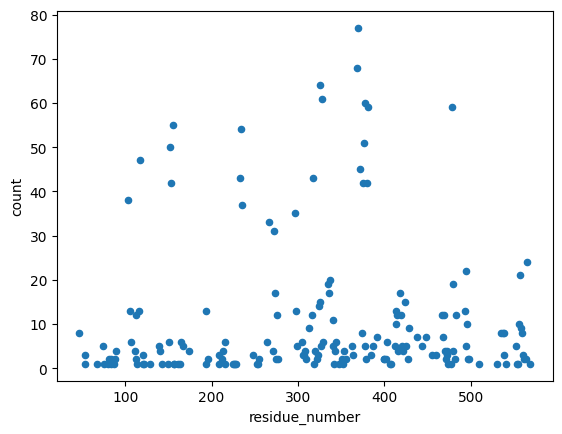

In [13]:
df4.plot.scatter(x='residue_number', y='count')

We can the determine the mean number of interactions and the standard deviation

In [14]:
mean = df4.mean()
std = df4.std()
print("Mean:")
print(mean)
print("Standard deviation:")
print(std)

Mean:
residue_number    322.565934
count              10.945055
dtype: float64
Standard deviation:
residue_number    144.868634
count              15.981593
dtype: float64


We need to extract the standard deviation value as a number from the above result

In [15]:
mean_value = float(mean.values[1])
std_value = float(std.values[1])
print(mean_value, std_value)

10.945054945054945 15.9815934437868


Then we can plot residues which have more interactions than the mean in red
and those which are equal to or below in blue.

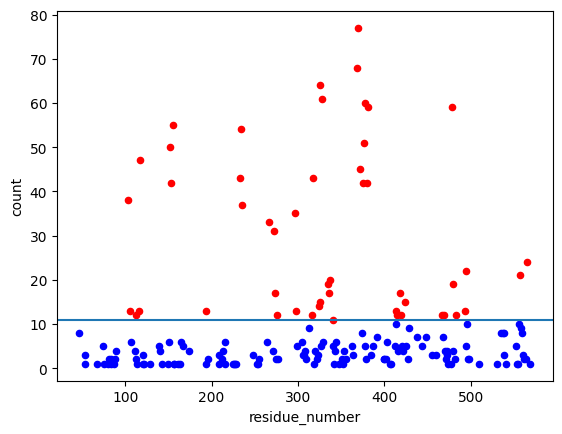

In [16]:
fig, ax = plt.subplots() # this makes one plot with an axis "ax" which we can add several plots to
df4.query('count <= {}'.format(mean_value)).plot.scatter(x='residue_number', y='count', color='blue', ax=ax)
df4.query('count > {}'.format(mean_value)).plot.scatter(x='residue_number', y='count', color='red', ax=ax)
ax.axhline(mean_value)
plt.show()
plt.close()

A higher threshold (two standard deviations) would be more useful to select only the most common ligand-binding residues

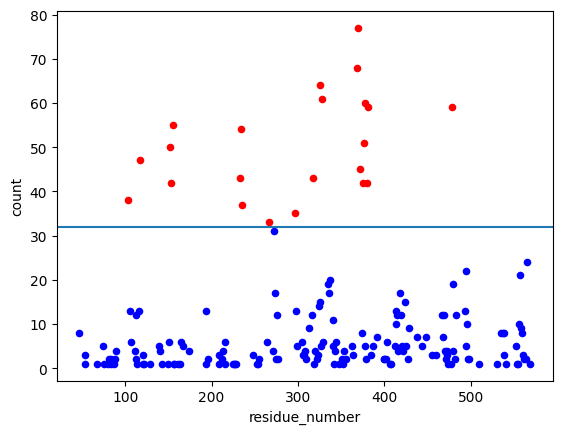

In [17]:
two_std_value = std_value * 2
fig, ax = plt.subplots() # this makes one plot with an axis "ax" which we can add several plots to
df4.query('count <= {}'.format(two_std_value)).plot.scatter(x='residue_number', y='count', color='blue', ax=ax)
df4.query('count > {}'.format(two_std_value)).plot.scatter(x='residue_number', y='count', color='red', ax=ax)
ax.axhline(two_std_value)
plt.show()
plt.close()


The actual residues are

In [18]:
all_data_over_two_std = df4.query('count > {}'.format(two_std_value)).sort_values(by='count', ascending=False)
all_data_over_two_std


,residue_number,count
106,369,77
105,368,68
86,326,64
88,328,61
112,378,60
115,381,59
152,478,59
33,155,55
55,234,54
110,376,51


we only want the residue numbers for the next step

In [19]:
residue_numbers_over_two_std = all_data_over_two_std['residue_number']
residue_numbers_over_two_std

106    369
105    368
86     326
88     328
112    378
115    381
152    478
33     155
55     234
110    376
31     152
21     117
107    372
79     317
54     233
109    375
32     153
114    380
13     103
56     235
69     296
62     267
Name: residue_number, dtype: int64

What ligands interact with these residues?

Now we want to get all ligand_accessions which interact with a residue in "residue_numbers_over_two_std"

In [20]:
df5  = df3[df3['residue_number'].isin(residue_numbers_over_two_std)]['ligand_accession']
df5

2       THA
3       THA
4       THA
5       THA
7       THA
       ... 
1919     CL
1920     CL
1921     CL
1922     CL
1923     CL
Name: ligand_accession, Length: 1105, dtype: object

The same ligand appears several times so we an "unique" the list to get our list of ligands
which have a number of interactions over the mean interaction count.

In [21]:
interesting_ligands = list(df5.unique())
interesting_ligands

['THA',
 'AA',
 '4IX',
 '4J1',
 '3VI',
 'HLO',
 'HI6',
 'LND',
 'CVZ',
 'E20',
 'H0R',
 'H1R',
 'H0L',
 '1YK',
 '1YL',
 'EBW',
 'QRH',
 'FP1',
 'HUP',
 'MES',
 'PQY',
 'FUL',
 'FUC',
 'NAG',
 'PQV',
 'WW2',
 'UCY',
 'GNT',
 'HUW',
 'GOL',
 'EFS',
 'ELT',
 'GD8',
 'UCJ',
 'NWA',
 'DMS',
 'L2Y',
 'DEP',
 'L1M',
 'L0S',
 'VX',
 'SO4',
 'CL']

It's worth seeing which ligands are not in our list

In [22]:
all_ligands = list(df3['ligand_accession'].unique())

missing_ligands = [x for x in all_ligands if x not in interesting_ligands]
missing_ligands

['GAL', 'SIA', 'BR', '1PE', 'MG', 'PE8', '7PE', 'PEG', 'EDO', 'NO3']

Now we can display the interactions only for those ligands we have found

We will start with our Dataframe df3

In [23]:
df3.head()

,startIndex,endIndex,startCode,endCode,indexType,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio,pdbId,entityId,chainIds,residue_number,count
0,113,113,GLY,GLY,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,B,113,7xn1
1,114,114,THR,THR,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,B,114,7xn1
2,117,117,TRP,TRP,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,B,117,7xn1
3,233,233,GLU,GLU,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,B,233,7xn1
4,368,368,TYR,TYR,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,B,368,7xn1


We will select only ligands which interact the most in a Dataframe df6

In [24]:
df6 = df3.groupby(['residue_number', 'ligand_accession'])['interaction_ratio'].mean().reset_index()

We are going to scale the interactions as we use this later

In [25]:
df6['interaction_ratio'] = df6['interaction_ratio'].apply(lambda x: x*2)
df6

,residue_number,ligand_accession,interaction_ratio
0,47,CL,1.428571
1,47,SO4,0.750000
2,53,SO4,0.250000
3,54,CL,0.285714
4,54,SO4,0.500000
...,...,...,...
680,565,CL,0.285714
681,565,EDO,2.000000
682,565,NO3,0.631579
683,565,SO4,1.250000


Now we can plot the ligand interactions of those ligands which interact with the most interacting residues.

We will put each ligand on a row and scale the interactions by the percentage of PDB entries they are seen in.


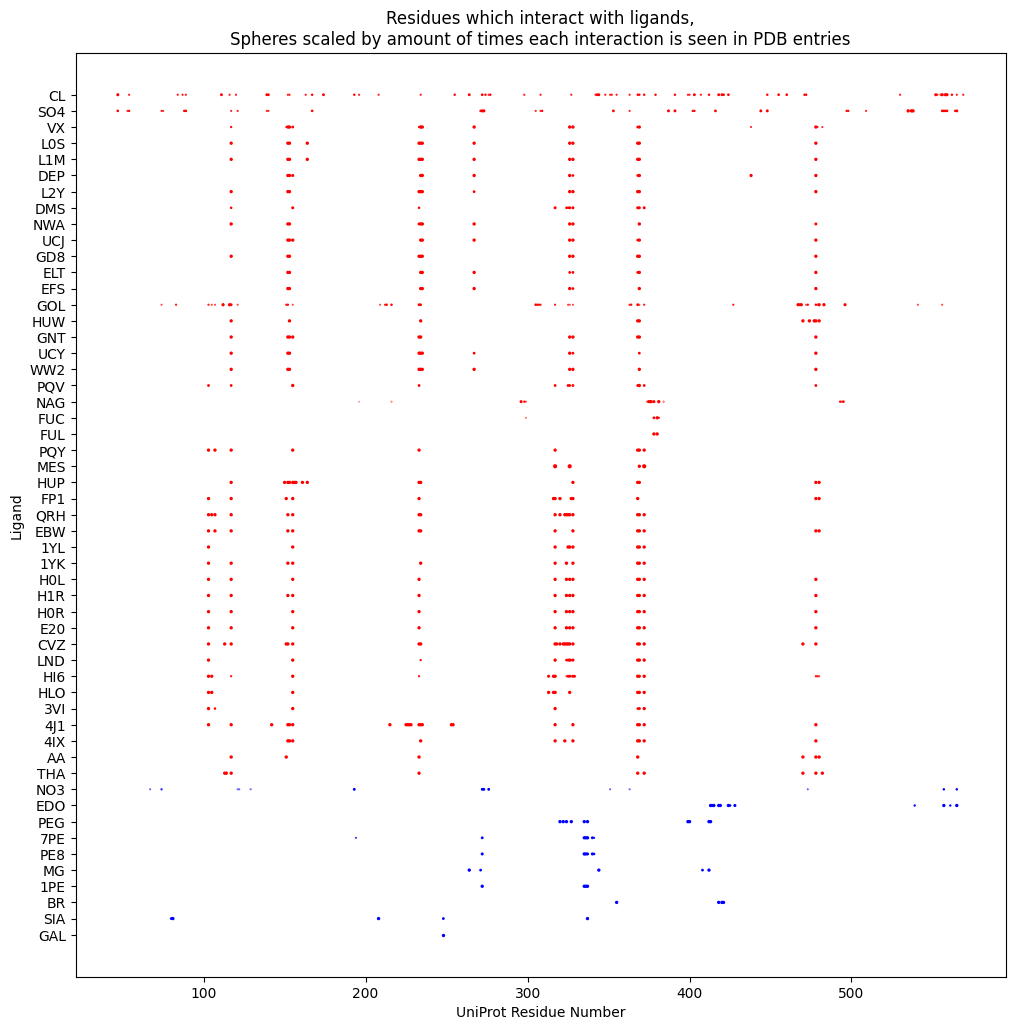

In [26]:
# prepare a figure
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

# plot the less interesting ligands in blue
for ligand in missing_ligands:
    data = df6[df6['ligand_accession'] == ligand]
    data.plot.scatter(x='residue_number', y='ligand_accession', ax=ax, s='interaction_ratio', c='blue')

# plot the interesting ligands in red
for ligand in interesting_ligands:
    data = df6[df6['ligand_accession'] == ligand]
    data.plot.scatter(x='residue_number', y='ligand_accession', ax=ax, s='interaction_ratio', c='red')


plt.ylabel('Ligand')
plt.xlabel('UniProt Residue Number')
plt.title('Residues which interact with ligands,\nSpheres scaled by amount of times each interaction is seen in PDB entries')
plt.show()
plt.close()

It would be interesting to see if the ligands binding to same residues are similar to each other. Let's take any ligand from above interesting ligand dataset and find all the other ligands which are similar to it. 

In the example below, we have taken the neurotoxin VX (HET CODE- VX) and acetylcholinesterase inhibitor. We found all the ligands similar to VX using "get_similar_ligand_data" function. This function takes ligand name and similarity cutoff (0-1) as arguments. Here we have used similarity cutoff of 0.7 and found all the ligands which are 70 % or more similar to VX. 

In [29]:
ligand_exp = "VX"
similarity_cutoff = 0.7
#finding similar ligands to ligand_exp 
similar_ligands = get_similar_ligand_data(ligand_exp, similarity_cutoff)
sdf=pd.DataFrame(similar_ligands.items(),columns = ['similar_ligand','similarity_score'])
print(sdf)
#find common ligands from similar_ligands and interesting_ligands
common_ligands = [item for item in similar_ligands if item in interesting_ligands]
print(f"common ligands include - {common_ligands}")

https://www.ebi.ac.uk/pdbe/graph-api/compound/similarity/VX
  similar_ligand  similarity_score
0            ATJ             0.857
1            CVX             0.778
2            E8W             0.778
3            E9E             0.875
4            EFS             0.750
5             GB             0.714
6            H9A             0.778
7             VR             0.778
common ligands include - ['EFS']


Now, you can compare if VX and common_ligands bind to same residues or not and check if similar ligands tend to bind to similar sites.

In [56]:
# get the binding site for your ligand of interest
binding_site_1=sorted(df3[df3['ligand_accession'] == 'VX']['residue_number'].unique())
print(f"binding site for VX: {binding_site_1}")
# get binding site for common ligands 
common_binding_residues = []
for ligand in common_ligands :
    binding_site_2=sorted(df3[df3['ligand_accession'] == ligand]['residue_number'].unique())
    print(f"binding site for {ligand}: {binding_site_2}")
    common_binding_residues += [item for item in binding_site_2 if item in binding_site_1]
print(f"common binding site residues {common_binding_residues}")

binding site for VX: [117, 151, 152, 153, 155, 233, 234, 235, 267, 326, 328, 368, 369, 438, 478, 479, 482]
binding site for EFS: [152, 153, 234, 235, 267, 326, 328, 369, 478]
